# 糖尿病数据分析

## 1 加载库

In [3]:
# -*- coding: utf-8 -*-
"""
糖尿病数据分析
"""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

## 2 导入数据集并查看

In [4]:
diabetes = pd.read_csv(r'F:\MLwork\Diabete\diabetes.csv')              #导入diabetes原始数据
print(diabetes.shape)                                                  #查看数据集大小
diabetes.head()
print(diabetes)                                      
print(diabetes.describe())                                             #描述统计
diabetes.info()                                                        #给出样本数据相关信息概览

(768, 9)
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1         

## 3 数据清洗及预处理

In [5]:
diabetes_copy = diabetes.copy(deep = True)                          #复制数据进行处理
# 对Glucose、BloodPressure、SkinThickness、Insulin、BMI预处理（有缺失的）
diabetes_copy[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = \
diabetes_copy[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)    #存在无效的0值，将所有0值替换为NaN
diabetes_copy.isnull().sum()                                        #样本中各变量缺失值统计

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool


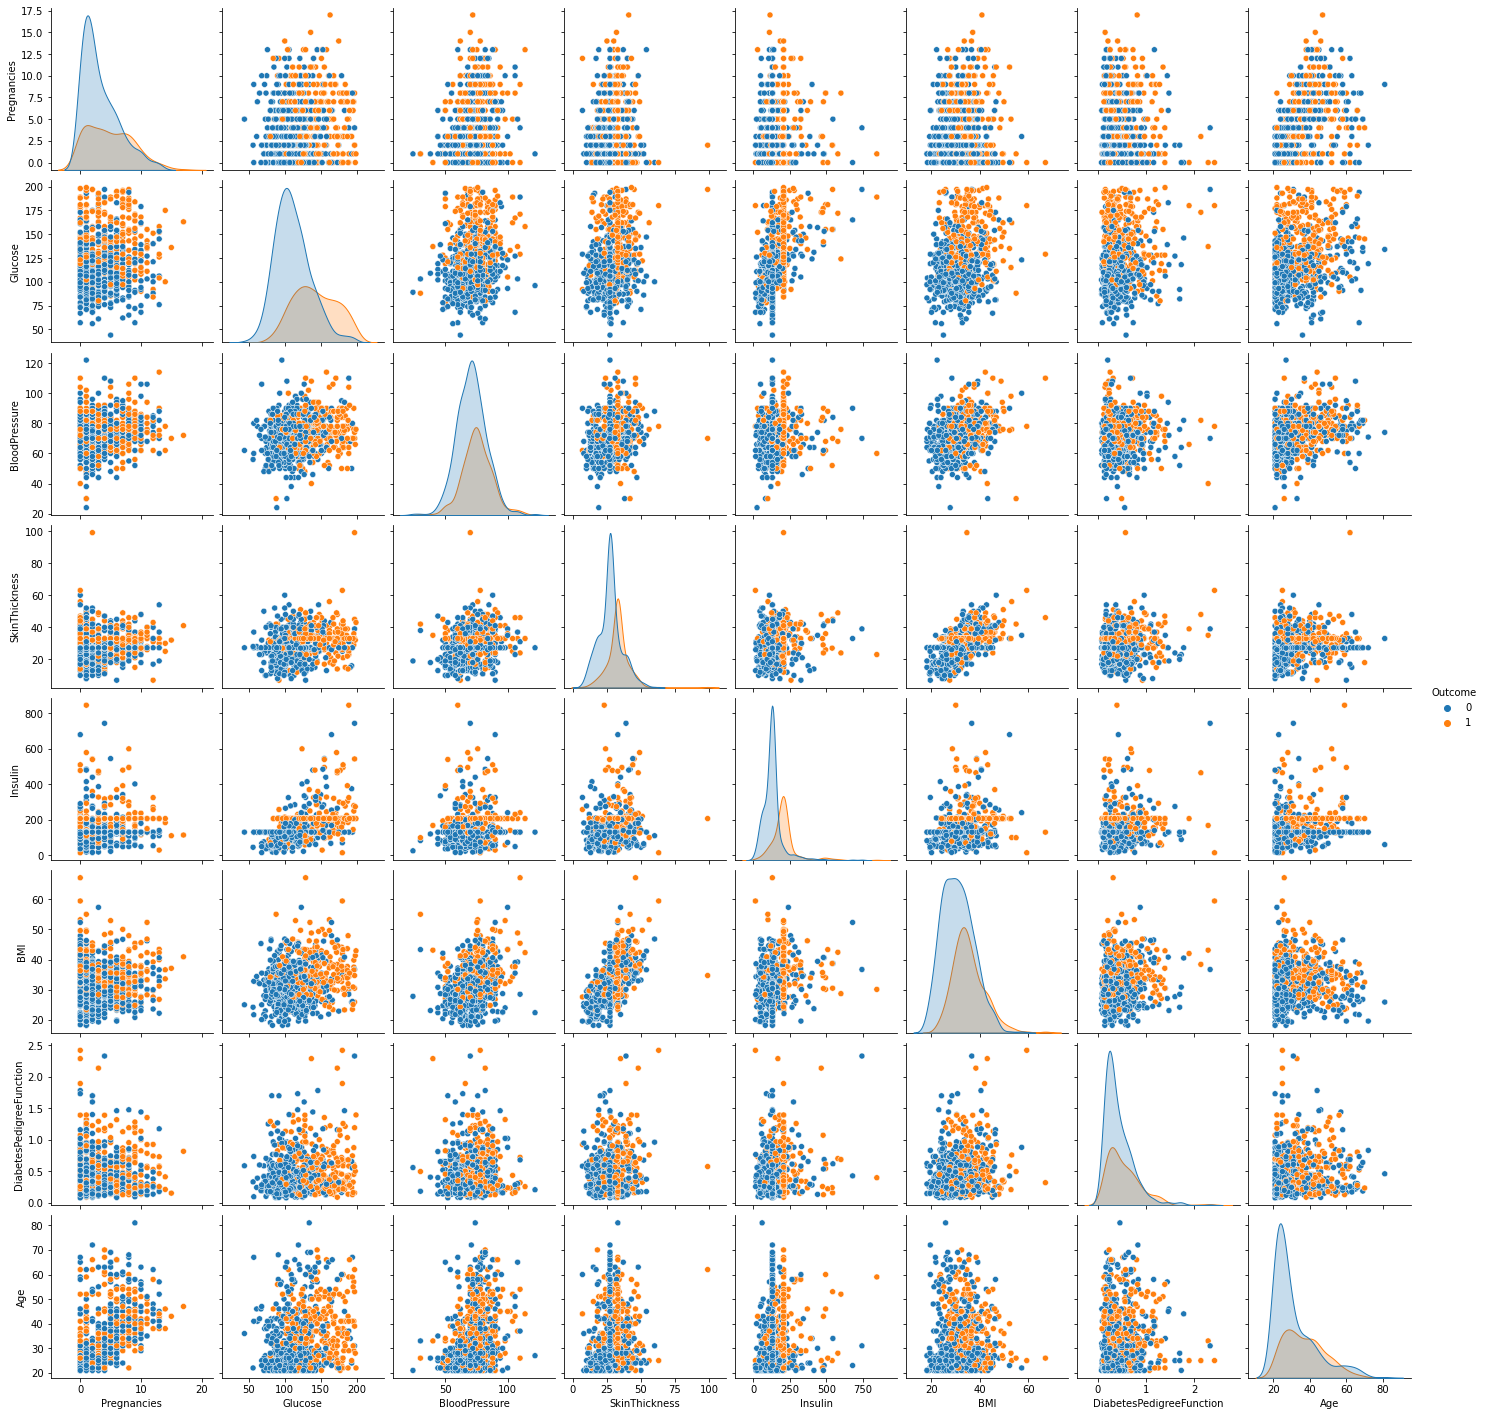

In [6]:
def mean_filler (index):                   # 计算各变量均值(以是否患糖尿病为划分依据，分别取均值)，填充缺失
    temp = diabetes_copy[diabetes_copy[index].notnull()]
    temp = temp[[index, 'Outcome']].groupby(['Outcome'])[[index]].mean().reset_index()
    return temp

mean_filler('Glucose')                    # Glucose缺失值填充
diabetes_copy.loc[(diabetes_copy['Outcome'] == 0) & (diabetes_copy['Glucose'].isnull()), 'Glucose'] = mean_filler('Glucose')['Glucose'][0]
diabetes_copy.loc[(diabetes_copy['Outcome'] == 1) & (diabetes_copy['Glucose'].isnull()), 'Glucose'] = mean_filler('Glucose')['Glucose'][1]

mean_filler('BloodPressure')            # BloodPressure缺失值填充
diabetes_copy.loc[(diabetes_copy['Outcome'] == 0) & (diabetes_copy['BloodPressure'].isnull()), 'BloodPressure'] = mean_filler('BloodPressure')['BloodPressure'][0]
diabetes_copy.loc[(diabetes_copy['Outcome'] == 1) & (diabetes_copy['BloodPressure'].isnull()), 'BloodPressure'] = mean_filler('BloodPressure')['BloodPressure'][1]

mean_filler('SkinThickness')             # SkinThickness缺失值填充
diabetes_copy.loc[(diabetes_copy['Outcome'] == 0) & (diabetes_copy['SkinThickness'].isnull()), 'SkinThickness'] = mean_filler('SkinThickness')['SkinThickness'][0]
diabetes_copy.loc[(diabetes_copy['Outcome'] == 1) & (diabetes_copy['SkinThickness'].isnull()), 'SkinThickness'] = mean_filler('SkinThickness')['SkinThickness'][1]

mean_filler('Insulin')                   # Insulin缺失值填充
diabetes_copy.loc[(diabetes_copy['Outcome'] == 0) & (diabetes_copy['Insulin'].isnull()), 'Insulin'] = mean_filler('Insulin')['Insulin'][0]
diabetes_copy.loc[(diabetes_copy['Outcome'] == 1) & (diabetes_copy['Insulin'].isnull()), 'Insulin'] = mean_filler('Insulin')['Insulin'][1]

mean_filler('BMI')                       # BMI缺失值填充
diabetes_copy.loc[(diabetes_copy['Outcome'] == 0) & (diabetes_copy['BMI'].isnull()), 'BMI'] = mean_filler('BMI')['BMI'][0]
diabetes_copy.loc[(diabetes_copy['Outcome'] == 1) & (diabetes_copy['BMI'].isnull()), 'BMI'] = mean_filler('BMI')['BMI'][1]
print(diabetes_copy.isnull().any())                 #填充后，查看各列缺失值，数据集无缺失值
sns.pairplot(diabetes_copy, hue = 'Outcome')        #绘热力图(Outcome)
plt.show()

### 此时样本已无缺失值，故对填补后数据进行描述统计，了解各变量取值状况。

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.697358      72.428141      29.247042  157.003527   
std       3.369578   30.462008      12.106044       8.923908   88.860914   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.000000      28.000000  130.287879   
75%       6.000000  141.000000      80.000000      33.000000  206.846154   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

             BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.00000                768.000000  768.000000  768.000000  
mean    32.44642                  0.471876   33.240885    0.348958  
std      6.87897                  0.331329   11.760232    0.476951  
min     18.20000                  0.078

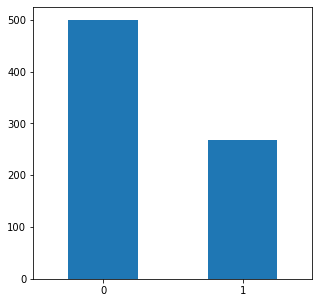

In [7]:
print(diabetes_copy.describe())                     #填充后的描述统计
diabetes.Outcome.value_counts()                     #统计糖尿病人的数量(Outcome)，判断样本是否均衡
plt.figure(figsize = (5,5), facecolor='w')          #绘制Outcome柱形图
diabetes.Outcome.value_counts().plot.bar()
plt.xticks(rotation=0)
plt.show()

### 通过Outcome（标签值）的均值、标准差以及上面柱状图可知，样本取值分布良好，在此不考虑对其进行平衡处理。

### 判断相关性

Outcome                     1.000000
Glucose                     0.495954
Insulin                     0.410918
BMI                         0.315271
SkinThickness               0.308094
Age                         0.238356
Pregnancies                 0.221898
BloodPressure               0.175087
DiabetesPedigreeFunction    0.173844
Name: Outcome, dtype: float64


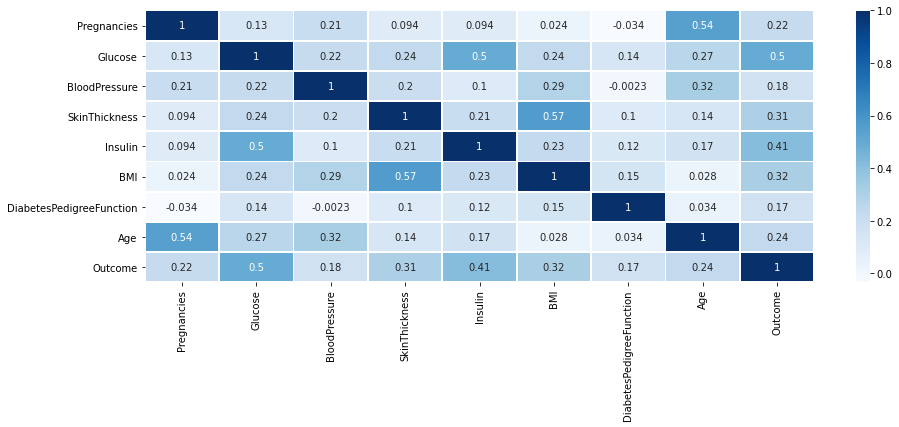

In [8]:
diabetes_corr = diabetes_copy.corr()                                  #计算相关系数
print(diabetes_corr['Outcome'].sort_values(ascending = False))        #找出相关系数最高的三个变量
plt.figure(figsize=(15, 5), facecolor='w')
sns.heatmap(diabetes_corr, vmax=1, square=False, annot=True, linewidth=1, cmap=plt.cm.Blues)     #绘制热力图
plt.show()

根据上图可发现，与Outcome相关性较高的有Glucose（葡萄糖）、Insulin（2小时血清胰岛素）、BMI、SkinThickness（皮层厚度），可重点关注，但因变量个数不是很多，后续分析中不进行特征抽取。

### 数据标准化处理

In [9]:
diabetes_st = StandardScaler()               # 对数据进行标准化处理
x = pd.DataFrame(diabetes_st.fit_transform(diabetes_copy.drop(['Outcome'], axis = 1),), columns = ['Pregnancies','Glucose','BloodPressure','SkinThick','Insulin','BMI','DiabetesPedigreeFunction', 'Age'])    #构建新特征DataFrame
x.head()

,Pregnancies,Glucose,BloodPressure,SkinThick,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.864020,-0.035389,0.645088,0.561272,0.167806,0.468492,1.425995
1,-0.844885,-1.205478,-0.531332,-0.027701,-0.300842,-0.850452,-0.365061,-0.190672
2,1.233880,2.013741,-0.696647,0.420825,0.561272,-1.330487,0.604397,-0.105584
3,-0.844885,-1.074081,-0.531332,-0.700491,-0.709475,-0.632253,-0.920763,-1.041549
4,-1.141852,0.502679,-2.680419,0.645088,0.123830,1.549727,5.484909,-0.020496


## 4 模型构建及预测

### 数据集划分

In [10]:
y = diabetes_copy.Outcome                  #原始标签值(Outcome)
train_X, test_X, train_y, test_y = train_test_split(x,y,train_size = .8,random_state = 0)    #拆分数据集，80%训练集和20%测试集
print('原始数据集特征：', x.shape,
     '训练数据集特征：', train_X.shape,
     '测试数据集特征：', test_X.shape)

print('原始数据集标签：',y.shape,
     '训练数据集标签：', train_y.shape,
     '测试数据集标签：', test_y.shape)

原始数据集特征： (768, 8) 训练数据集特征： (614, 8) 测试数据集特征： (154, 8)
原始数据集标签： (768,) 训练数据集标签： (614,) 测试数据集标签： (154,)


### 十折交叉验证

In [11]:
models = []
models.append(("LR", LogisticRegression()))           #Logistic回归
models.append(("DT", DecisionTreeClassifier()))       #决策树分类
models.append(("RF", RandomForestClassifier()))       #随机森林分类
results = []
names = []
for name, model in models:
    kflod = KFold(n_splits=10, random_state=None)       #进行十折交叉验证
    cv_result = cross_val_score(model,train_X,train_y, cv = kflod,scoring="accuracy")
    names.append(name)
    results.append(cv_result)

for i in range(len(names)):
    print(names[i], results[i].mean)

LR <built-in method mean of numpy.ndarray object at 0x00000234C9848440>
DT <built-in method mean of numpy.ndarray object at 0x00000234CB150300>
RF <built-in method mean of numpy.ndarray object at 0x00000234CB16A620>


### 模型构建及评估：

#### 模型一：Logistic回归

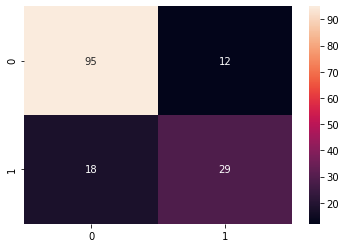



 ---Logistic回归---
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       107
           1       0.71      0.62      0.66        47

    accuracy                           0.81       154
   macro avg       0.77      0.75      0.76       154
weighted avg       0.80      0.81      0.80       154

Logistic AUC = 0.75
Logistic模型预测准确率为： 0.8051948051948052


In [12]:
lr = LogisticRegression()                      #模型构建
lr.fit(train_X,train_y)                        #模型训练
y_pre = lr.predict(test_X)                     #预测
# 进行模型评估
conf = confusion_matrix(test_y,y_pre)          #混淆矩阵
label = ["0","1"]                              #绘图
sns.heatmap(conf, annot = True, xticklabels=label, yticklabels=label)
plt.show()
lr_roc_auc = roc_auc_score(test_y, y_pre)
lr_accuracy = accuracy_score(test_y,y_pre)            #预测是否患糖尿病的准确率
print("\n\n ---Logistic回归---")
print(classification_report(test_y, y_pre))
print("Logistic AUC = %2.2f" % lr_roc_auc)
print('Logistic模型预测准确率为：',lr_accuracy)

#### 模型二：决策树

#### （1）决策树（未优化）

In [13]:
clf0 = DecisionTreeClassifier(criterion='entropy')    #创建决策树分类器（未优化）
clf0 = clf0.fit(train_X,train_y)                      #训练模型
y_pre = clf0.predict(test_X)                          #预测
dt_roc_auc0 = roc_auc_score(test_y, y_pre)            #auc
clf0_accuracy = accuracy_score(test_y, y_pre)         #模型的准确率
print("\n\n ---决策树(未优化)---")
print(classification_report(test_y, y_pre))
print("决策树0 AUC = %2.2f" % dt_roc_auc0)
print("决策树(未优化)预测准确率:",clf0_accuracy)



 ---决策树(未优化)---
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       107
           1       0.73      0.85      0.78        47

    accuracy                           0.86       154
   macro avg       0.83      0.86      0.84       154
weighted avg       0.87      0.86      0.86       154

决策树0 AUC = 0.86
决策树(未优化)预测准确率: 0.8571428571428571


#### （2）决策树（优化后）

In [14]:
clf1 =tree.DecisionTreeClassifier(                    # 创建决策树分类器（优化后），限定树的最大深度, 减少过拟合
    criterion='entropy',
    max_depth=3,                                      #定义树的深度, 可以用来防止过拟合
    min_weight_fraction_leaf=0.01                     #定义叶子节点最少需要包含多少样本(百分比), 防止过拟合
    )
clf1 = clf1.fit(train_X, train_y)                     #训练模型
y_pre = clf1.predict(test_X)
dt_roc_auc1 = roc_auc_score(test_y, y_pre)
clf1_accuracy = accuracy_score(test_y, y_pre)
print ("\n\n ---决策树(优化后)---")
print(classification_report(test_y, y_pre))
print ("决策树1 AUC = %2.2f" % dt_roc_auc1)
print("决策树(优化后)预测准确率:",clf1_accuracy)



 ---决策树(优化后)---
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       107
           1       0.77      0.94      0.85        47

    accuracy                           0.90       154
   macro avg       0.87      0.91      0.88       154
weighted avg       0.91      0.90      0.90       154

决策树1 AUC = 0.91
决策树(优化后)预测准确率: 0.8961038961038961


#### 模型三：随机森林

In [15]:
rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    max_depth=None,              #定义树的深度, 可以用来防止过拟合
    min_samples_split=10,        #定义至少多少个样本的情况下才继续分叉
    #min_weight_fraction_leaf=0.02 # 定义叶子节点最少需要包含多少个样本(使用百分比表达), 防止过拟合
    )
rf.fit(train_X, train_y)
y_pre = rf.predict(test_X)
print ("\n\n ---随机森林---")
rf_roc_auc = roc_auc_score(test_y, y_pre)
rf_accuracy = accuracy_score(test_y, y_pre)
print(classification_report(test_y, y_pre))
print ("随机森林 AUC = %2.2f" % rf_roc_auc)
print("随机森林预测准确率为:",rf_accuracy)



 ---随机森林---
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       107
           1       0.79      0.89      0.84        47

    accuracy                           0.90       154
   macro avg       0.87      0.90      0.88       154
weighted avg       0.90      0.90      0.90       154

随机森林 AUC = 0.90
随机森林预测准确率为: 0.8961038961038961


#### 模型预测结果比对

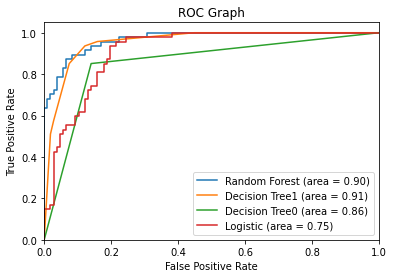

In [16]:
# 绘制ROC曲线进行模型比对
rf_fpr, rf_tpr, rf_thresholds = roc_curve(test_y, rf.predict_proba(test_X)[:,1])
dt_fpr1, dt_tpr1, dt_thresholds1 = roc_curve(test_y, clf1.predict_proba(test_X)[:,1])
dt_fpr0, dt_tpr0, dt_thresholds0 = roc_curve(test_y, clf0.predict_proba(test_X)[:,1])
lr_fpr, lr_tpr, lr_thresholds = roc_curve(test_y, lr.predict_proba(test_X)[:,1])
plt.figure()

#随机森林 ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
#决策树(优化后) ROC
plt.plot(dt_fpr1, dt_tpr1, label='Decision Tree1 (area = %0.2f)' % dt_roc_auc1)
#决策树(未优化) ROC
plt.plot(dt_fpr0, dt_tpr0, label='Decision Tree0 (area = %0.2f)' % dt_roc_auc0)
#Logistic  ROC
plt.plot(lr_fpr, lr_tpr, label='Logistic (area = %0.2f)' % lr_roc_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

## 基于上述模型，选择其中的优化决策树模型对是否患糖尿病预测最好，随机森林模型预测效果与其相近。